In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
from tqdm.notebook import trange, tqdm
import joblib
import os
from sklearn.preprocessing import Normalizer , StandardScaler

In [53]:
# https://www.kaggle.com/datasets/rohitrox/healthcare-provider-fraud-detection-analysis?select=Test-1542969243754.csv
import kaggle.cli
import sys
import pandas as pd
from pathlib import Path
from zipfile import ZipFile

# download data set
# https://www.kaggle.com/unsdsn/world-happiness?select=2017.csv
#https://www.kaggle.com/datasets/shashwatwork/insurance-claim-dataset?select=Inpatient_Claim.csv
dataset = "rohitrox/healthcare-provider-fraud-detection-analysis"
sys.argv = [sys.argv[0]] + f"datasets download {dataset}".split(" ")
kaggle.cli.main()

zfile = ZipFile(f"{dataset.split('/')[1]}.zip")

dfs = {f.filename:pd.read_csv(zfile.open(f)) for f in zfile.infolist() }

dfs

healthcare-provider-fraud-detection-analysis.zip: Skipping, found more recently modified local copy (use --force to force download)


{'Test-1542969243754.csv':       Provider
 0     PRV51002
 1     PRV51006
 2     PRV51009
 3     PRV51010
 4     PRV51018
 ...        ...
 1348  PRV57713
 1349  PRV57726
 1350  PRV57745
 1351  PRV57749
 1352  PRV57750
 
 [1353 rows x 1 columns],
 'Test_Beneficiarydata-1542969243754.csv':            BeneID         DOB         DOD  Gender  Race RenalDiseaseIndicator  \
 0       BENE11001  1943-01-01         NaN       1     1                     0   
 1       BENE11007  1940-09-01  2009-12-01       1     2                     0   
 2       BENE11010  1936-07-01         NaN       2     1                     0   
 3       BENE11011  1914-03-01         NaN       2     2                     0   
 4       BENE11014  1938-04-01         NaN       2     1                     Y   
 ...           ...         ...         ...     ...   ...                   ...   
 63963  BENE159187  1959-07-01         NaN       1     1                     0   
 63964  BENE159193  1936-12-01         NaN       2     1

In [54]:
dfs.keys()

dict_keys(['Test-1542969243754.csv', 'Test_Beneficiarydata-1542969243754.csv', 'Test_Inpatientdata-1542969243754.csv', 'Test_Outpatientdata-1542969243754.csv', 'Train-1542865627584.csv', 'Train_Beneficiarydata-1542865627584.csv', 'Train_Inpatientdata-1542865627584.csv', 'Train_Outpatientdata-1542865627584.csv'])

In [67]:
dfs['Train-1542865627584.csv']

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No
...,...,...
5405,PRV57759,No
5406,PRV57760,No
5407,PRV57761,No
5408,PRV57762,No


# Function 1
### Complete pipeline to take raw csv file and return predicted values

In [57]:
X_train = {'Inpatient_data_csv_file':'Train_Inpatientdata-1542865627584.csv',
    'Outpatient_data_csv_file':'Train_Outpatientdata-1542865627584.csv',
    'Beneficiary_data_csv_file':'Train_Beneficiarydata-1542865627584.csv',
    'Test_provider_ID_csv_file': 'Train-1542865627584.csv'}

In [96]:
def encoded_cat(dataset, feature_to_encode='',col_list=[]):
    """This function returns top 5 cat column useful in determining potential fraud"""
    outer_list =[]
    for col in col_list:
        list_1 = list()

        for item in list(dataset[col]):
            if str(item) == str(feature_to_encode):
                list_1.append(1)
            else:
                list_1.append(0)

        outer_list.append(list_1)

    li_sum = np.array([0]*merged_data.shape[0])

    for i in range(0,len(outer_list)):
        li1 = np.array(outer_list[i])
        li_sum = li_sum + li1

    return li_sum

def N_unique_values(df):
    """This function finds the unique values in a df row"""
    return np.array([len(set([i for i in x[~pd.isnull(x)]])) for x in df.values])

    
def num_col_normalizer(X,col=''):
    """This function retruns normalised column for train and test data"""
    normalizer = Normalizer()

    normalizer.fit(X[col].values.reshape(1,-1))
    X_norm = normalizer.transform(X[col].values.reshape(1,-1)).reshape(-1,1)
    return X_norm



def Predict_Fraud_providers(X):
    
    '''This function takes Inpatient,outpatient,Beneficiary and Provider Id in respective raw CSV file and flags predicted
    fradulent providers'''
    
    #if not os.path.isfile('final_test_data.csv'):
        
    print('Merging all raw data files together........')

    #read all input data 
    inpatient = dfs[X['Inpatient_data_csv_file']]
    outpatient = dfs[X['Outpatient_data_csv_file']]
    beneficiary = dfs[X['Beneficiary_data_csv_file']]
    Test_provider_ID = dfs[X['Test_provider_ID_csv_file']]

    #merging all raw data into one dataframe
    inpatient['is_admitted'] = 1
    outpatient['is_admitted'] = 0

    # Merge in_pt, out_pt and ben df into a single patient dataset
    merged_data = pd.merge(inpatient, outpatient,
                    left_on = [ idx for idx in outpatient.columns if idx in inpatient.columns],
                    right_on = [ idx for idx in outpatient.columns if idx in inpatient.columns],
                    how = 'outer').\
          merge(beneficiary,left_on='BeneID',right_on='BeneID',how='inner').\
          merge(Test_provider_ID, on='Provider',how='inner')
    print(merged_data['PotentialFraud'].head())


    print('Merging of raw data files Done !')
    print('')
    print('==================================================================================================')
    print('Start Data perocessing......')

    #perprocessing : 
    # Replace values with a binary annotation
    merged_data = merged_data.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
               'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2,
               'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2,
               'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2, 'Gender': 2 }, 
              0)

    # Replace values with a binary annotation
    merged_data = merged_data.replace({'RenalDiseaseIndicator': 'Y'}, 1).astype({'RenalDiseaseIndicator': 'int64'})
    #merging the dataset created in above step with target_data
    merged_data = pd.merge(merged_data, Test_provider_ID , how = 'outer', on = 'Provider' )


    #Adding a column is_dead  = 1  DOD is given else is_dead = 0 
    merged_data.loc[merged_data['DOD'].isnull(), 'Is_Dead'] = '0'
    merged_data.loc[(merged_data['DOD'].notnull()), 'Is_Dead'] = '1'

    merged_data['DOB'] =  pd.to_datetime(merged_data['DOB'], format='%Y-%m-%d')  
    merged_data['ClaimStartDt'] = pd.to_datetime(merged_data['ClaimStartDt'], format='%Y-%m-%d')  

    #now = pd.to_datetime('2020-09-01' , format = '%Y-%m-%d')
    merged_data['DOB'] = merged_data['DOB'].where(merged_data['DOB'] < merged_data['ClaimStartDt']) 
    merged_data['age'] = (merged_data['ClaimStartDt'] - merged_data['DOB']).astype('<m8[Y]')

    merged_data = merged_data.drop(['DOD'], axis = 1)
    merged_data = merged_data.drop(['DOB'], axis = 1)

    merged_data['AdmissionDt'] = pd.to_datetime(merged_data['AdmissionDt'] , format = '%Y-%m-%d')
    merged_data['DischargeDt'] = pd.to_datetime(merged_data['DischargeDt'],format = '%Y-%m-%d')
    merged_data['Num_admit_days'] = ((merged_data['DischargeDt'] - merged_data['AdmissionDt']).dt.days)+1
    merged_data.loc[merged_data['is_admitted'] == 0, 'Num_admit_days'] = '0'

    merged_data = merged_data.drop(['DischargeDt'], axis = 1)
    merged_data = merged_data.drop(['AdmissionDt'], axis = 1)

    #repalcing NaN value with 0
    merged_data.loc[merged_data['DeductibleAmtPaid'].isnull(),'DeductibleAmtPaid'] = 0

    Diag_proce_col = ['ClmAdmitDiagnosisCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_10',
                  'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
                  'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
                  'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmProcedureCode_1',
                  'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
                  'ClmProcedureCode_5', 'ClmProcedureCode_6']

    merged_data[Diag_proce_col]= merged_data[Diag_proce_col].replace({np.nan:0})

    



    procedure_col = ['ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3','ClmProcedureCode_4','ClmProcedureCode_5','ClmProcedureCode_6']

    diagnosis_col = ['ClmDiagnosisCode_1','ClmDiagnosisCode_2','ClmDiagnosisCode_3','ClmDiagnosisCode_4','ClmDiagnosisCode_5','ClmDiagnosisCode_6','ClmDiagnosisCode_7','ClmDiagnosisCode_8','ClmDiagnosisCode_9','ClmDiagnosisCode_10']


    #top 5 procedure
    # 4019.0, 2724.0, 9904.0, 8154.0, 66.0
    merged_data['pr_4019'] = encoded_cat(merged_data,'4019.0',procedure_col)
    merged_data['pr_2724'] = encoded_cat(merged_data,'2724.0',procedure_col)
    merged_data['pr_9904'] = encoded_cat(merged_data,'9904.0',procedure_col)
    merged_data['pr_8154'] = encoded_cat(merged_data,'8154.0',procedure_col)
    merged_data['pr_66'] =   encoded_cat(merged_data,'66.0',procedure_col)

    #top 5 diagnosis 
    #4019,25000,2724,V5869,42731
    merged_data['di_4019'] = encoded_cat(merged_data,'4019',diagnosis_col)
    merged_data['di_25000'] = encoded_cat(merged_data,'25000',diagnosis_col)
    merged_data['di_2724'] = encoded_cat(merged_data,'2724',diagnosis_col)
    merged_data['di_V5869'] = encoded_cat(merged_data,'V5869',diagnosis_col)
    merged_data['di_42731'] =   encoded_cat(merged_data,'42731',diagnosis_col)

    for i in Diag_proce_col:
        merged_data[i][merged_data[i]!=0]= 1

    merged_data[Diag_proce_col]= merged_data[Diag_proce_col].astype(float)
    '''---------------------------------------------------------------------------------------------------------------'''
    #adding column total_num_diag
    merged_data['total_num_diag'] = 0 
    for col in diagnosis_col :
        merged_data['total_num_diag']  = merged_data['total_num_diag'] + merged_data[col]
    #print(merged_data.shape)

    #adding column total_num_proce
    merged_data['total_num_proce'] = 0 
    for col in procedure_col :
        merged_data['total_num_proce']  = merged_data['total_num_proce'] + merged_data[col]

    merged_data['total_num_diag'] =  merged_data['total_num_diag'].astype(float)
    merged_data['total_num_proce'] =  merged_data['total_num_proce'].astype(float)
    #print(merged_data.shape)
    '''---------------------------------------------------------------------------------------------------------------'''

    val_counts_ = merged_data['BeneID'].value_counts()
    tr_data_final_beneid_df = val_counts_.to_frame() #store this information in dataframe

    tr_data_final_beneid_df.columns = ['count'] 
    tr_data_final_beneid_df['BeneID'] = tr_data_final_beneid_df.index

    total_amt_list = []
    mean_amt_list = []

    for benid in tqdm(tr_data_final_beneid_df['BeneID']):

        total_amt = merged_data.loc[merged_data['BeneID'] == benid,'InscClaimAmtReimbursed'].sum() 
        mean_amt = total_amt / (tr_data_final_beneid_df.loc[tr_data_final_beneid_df['BeneID'] == benid,'count'])

        total_amt_list.append(total_amt)
        mean_amt_list.append(mean_amt)

    mean_list = []
    for item in tqdm(mean_amt_list):
        mean_list.append(item[0])


    tr_data_final_beneid_df['mean_InscClaimAmtReimbursed']=mean_list
    tr_data_final_beneid_df['total_InscClaimAmtReimbursed']=total_amt_list


    merged_data = pd.merge(merged_data, tr_data_final_beneid_df, how='outer', on='BeneID')
    merged_data[['mean_InscClaimAmtReimbursed','total_InscClaimAmtReimbursed']]= merged_data[['mean_InscClaimAmtReimbursed','total_InscClaimAmtReimbursed']].astype(float)

    '''---------------------------------------------------------------------------------------------------------------'''



        
    #number of unique physicians for each patient
    merged_data['N_unique_Physicians'] = N_unique_values(merged_data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']]) 

    #encoding types of physicians into numeric values
    merged_data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']] = np.where(merged_data[['AttendingPhysician','OperatingPhysician',
                                                                                  'OtherPhysician']].isnull(), 0, 1)

    # number of different physicians who attend a patient
    merged_data['N_Types_Physicians'] = merged_data['AttendingPhysician'] + merged_data['OperatingPhysician'] + merged_data['OtherPhysician']

    # patients who was attended by only 1 physicians
    merged_data['Same_Physician'] = merged_data.apply(lambda x: 1 if (x['N_unique_Physicians'] == 1 and x['N_Types_Physicians'] > 1) else 0,axis=1)

    #determine if 1 physician has multi[le role to attend a patient
    merged_data['Same_Physician2'] = merged_data.apply(lambda x: 1 if (x['N_unique_Physicians'] == 2 and x['N_Types_Physicians'] > 2) else 0,axis=1)

    merged_data['DiagnosisGroupCode']= merged_data['DiagnosisGroupCode'].replace({np.nan:0})

    print('Data processing Done !')

    merged_data.to_csv('final_test_data.csv',index= False)
    print('Final Test dataset shape : ',merged_data.shape)
        
     
    
    
    col_to_remove = ['BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician',\
                 'OperatingPhysician', 'OtherPhysician','ClmAdmitDiagnosisCode','NoOfMonths_PartACov',\
                 'NoOfMonths_PartBCov','DiagnosisGroupCode']
    
    merged_data.drop(columns=col_to_remove, axis=1, inplace=True)

    
    Provider_ID = merged_data['Provider'].values
    merged_data.drop(columns='Provider', axis=1, inplace=True)
    return merged_data


# merged_data= Predict_Fraud_providers(X_train)

# print(prediction_df)
    

Merging all raw data files together........
0    Yes
1    Yes
2    Yes
3    Yes
4    Yes
Name: PotentialFraud, dtype: object
Merging of raw data files Done !

Start Data perocessing......


  0%|          | 0/138556 [00:00<?, ?it/s]

  0%|          | 0/138556 [00:00<?, ?it/s]

Data processing Done !
Final Test dataset shape :  (558211, 75)
None


In [97]:

#InscClaimAmtReimbursed
X_norm = num_col_normalizer(merged_data ,col='InscClaimAmtReimbursed')
merged_data['InscClaimAmtReimbursed'] = X_norm

X_norm = num_col_normalizer(merged_data ,col='DeductibleAmtPaid')
merged_data['DeductibleAmtPaid'] = X_norm

X_norm = num_col_normalizer(merged_data, col='IPAnnualReimbursementAmt')
merged_data['IPAnnualReimbursementAmt'] = X_norm

X_norm = num_col_normalizer(merged_data ,col='IPAnnualDeductibleAmt')
merged_data['IPAnnualDeductibleAmt'] = X_norm

X_norm = num_col_normalizer(merged_data ,col='OPAnnualReimbursementAmt')
merged_data['OPAnnualReimbursementAmt'] = X_norm

X_norm = num_col_normalizer(merged_data ,col='OPAnnualDeductibleAmt')
merged_data['OPAnnualDeductibleAmt'] = X_norm

X_norm = num_col_normalizer(merged_data ,col='mean_InscClaimAmtReimbursed')
merged_data['mean_InscClaimAmtReimbursed'] = X_norm

X_norm = num_col_normalizer(merged_data ,col='total_InscClaimAmtReimbursed')
merged_data['total_InscClaimAmtReimbursed'] = X_norm

X_norm = num_col_normalizer(merged_data ,col='age')
merged_data['age'] = X_norm

X_norm = num_col_normalizer(merged_data ,col='Num_admit_days')
merged_data['Num_admit_days'] = X_norm

X_norm = num_col_normalizer(merged_data ,col='N_unique_Physicians')
merged_data['N_unique_Physicians'] = X_norm

X_norm = num_col_normalizer(merged_data ,col='N_Types_Physicians')
merged_data['N_Types_Physicians'] = X_norm

'''--------------------------------------------------------------------------------------------------------------'''
print('Final Test dataset shape after all preprocessing : ',merged_data.shape)


Final Test dataset shape after all preprocessing :  (558211, 63)


In [103]:
merged_data['PotentialFraud'] = merged_data['PotentialFraud_y'].map({'Yes':1, 'No':0})
merged_data['PotentialFraud']

0         1
1         0
2         0
3         1
4         1
         ..
558206    0
558207    0
558208    0
558209    0
558210    0
Name: PotentialFraud, Length: 558211, dtype: int64

In [106]:
merged_data.drop(['PotentialFraud_y','PotentialFraud_x'],axis=1, inplace=True)

In [107]:
merged_data.to_csv('~/merged_data_health_fraud.csv')

In [116]:
merged_data.select_dtypes('object').head()

,Is_Dead
0,0
1,0
2,0
3,0
4,0


In [117]:
merged_data.Is_Dead = merged_data.Is_Dead.astype('int')

In [118]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    merged_data[[x for x in merged_data.columns if x!='PotentialFraud']], merged_data['PotentialFraud'],\
    test_size=0.33, random_state=42)

In [119]:
from lightgbm import LGBMClassifier
""" HELPER FUNCTION: GET ERROR RATE ========================================="""
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))

In [126]:
clf = LGBMClassifier(n_estimators=400, verbose=-1)
clf.fit(X_train, y_train)

LGBMClassifier(n_estimators=400, verbose=-1)

In [121]:
# pred_train = clf.predict(X_train)
# pred_test = clf.predict(X_test)

In [127]:
# Predict on training and test sets
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

# Calculate error rates
er_train = get_error_rate(pred_train, y_train)
er_test = get_error_rate(pred_test, y_test)

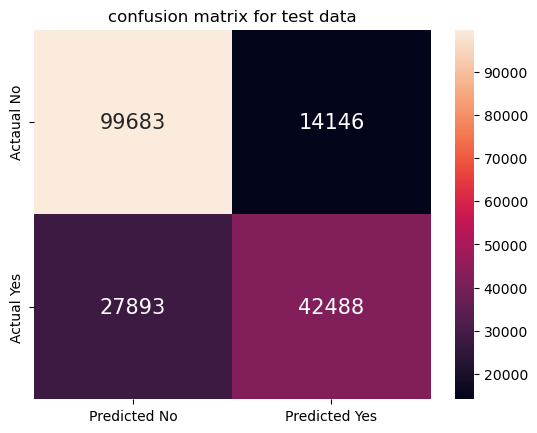

Model test F1 score is :  0.6690233436995631
Model test AUC score is :  0.7397057616523118


In [128]:
def get_confusion_matrix(y, y_pred, best_t = 0.362):
    cm = pd.DataFrame(confusion_matrix(y, predict_with_best_t(y_pred, best_t)))
    sns.heatmap(cm, annot = True, fmt= 'd',annot_kws={"size": 15}, xticklabels= ['Predicted No', 'Predicted Yes'], yticklabels= ['Actaual No','Actual Yes'])

#     y_pred_prob = mm_LR.predict_proba(mm_x_test)[:,1]
#     test_fpr, test_tpr, thresholds = roc_curve(y, y_pred_prob)

#     pred_output = predict_with_best_t(y_pred_prob, threshould = 0.362)

#test confusion matrix heatmap
get_confusion_matrix(y_test, pred_test, best_t=0.362)
plt.title("confusion matrix for test data")
plt.show()

model_f1_score = metrics.f1_score(y_test,pred_test)
print("Model test F1 score is : ",model_f1_score)

test_fpr, test_tpr, thresholds = roc_curve(y_test,pred_test)

model_AUC_score = metrics.auc(test_fpr, test_tpr)
print("Model test AUC score is : ",model_AUC_score)